In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
vals_1 = {
    'm1':0.5126,
    'm2':0.9998,
    'k1':230,
    'k2':72.5
}

vals_2 = { 
    'm1':0.9998, 
    'm2':0.5126, 
    'k1':230, 
    'k2':72.5
}

### Rensa datan av headers som orsakar massa problem i grafningen

In [3]:
from pathlib import Path
from sys import platform

# get all .tsv files in current directory
tsv_files = list(Path(".").glob("*.tsv"))
def clean_data(files, out_dir):  
    out_dir.mkdir(exist_ok=True)
    for file_path in files:
        out_path = out_dir / file_path.name
        print(f"Processing {file_path} → {out_path}")
    
        # read file as text and skip first 10 lines
        with file_path.open("r", encoding="utf-8") as infile:
            lines = infile.readlines()[11:]  # skip the first 10 lines
    
        # write the rest to the new file
        with out_path.open("w", encoding="utf-8") as outfile:
            outfile.writelines(lines)
clean_data(tsv_files, Path("data"))

Processing 1_f3.tsv → data/1_f3.tsv
Processing 2_f1.tsv → data/2_f1.tsv
Processing 1_bad.tsv → data/1_bad.tsv
Processing 2_f2.tsv → data/2_f2.tsv
Processing 4_f1.tsv → data/4_f1.tsv
Processing 1_f2_notgood.tsv → data/1_f2_notgood.tsv
Processing 3_f1.tsv → data/3_f1.tsv
Processing 13_uneven_z.tsv → data/13_uneven_z.tsv
Processing 2_bad.tsv → data/2_bad.tsv
Processing 5_f1.tsv → data/5_f1.tsv
Processing 1_f1.tsv → data/1_f1.tsv


### Läs in och bearbeta data med pandas

In [4]:
from pathlib import Path
from pandas.errors import EmptyDataError

# Hämta alla .tsv-filer i katalogen "data"
file_paths = list(Path("data").glob("*.tsv"))

# Skapa en ordbok (dict) där nyckeln = filnamn utan ändelse, värdet = dataframe
dfs = {}

for path in file_paths:
    try:
        name = path.stem  # Filnamn utan .tsv
        df = pd.read_csv(path, sep='\t', header=None)
        dfs[name] = df
        print(f"Läste in {name}")
    except EmptyDataError:
        print(f"Fel vid inläsning av {path}. Filen är tom eller saknas.")
    except Exception as e:
        print(f"Fel vid inläsning av {path}. {e}")

# Exempel: komma åt en specifik dataframe
df_1_f1 = dfs["1_f1"]

df_1_f1.columns = ["x2", "y2", "z2", "x1", "y1", "z1"]
df = df_1_f1/1000

#t = np.array(range(len(df)))
t=np.arange(0.01,10,0.01)


z1_diff = (df.z1 - np.mean(df.z1))
z2_diff = (df.z2 - np.mean(df.z2))

Läste in 1_f3
Läste in 2_f1
Läste in 1_bad
Läste in 2_f2
Läste in 4_f1
Fel vid inläsning av data/1_f2_notgood.tsv. Filen är tom eller saknas.
Läste in 1_dålig
Läste in 3_f1
Läste in 2_dålig
Läste in 13_uneven_z
Läste in 2_bad
Läste in 5_f1
Läste in 1_f1


### Fungerande grafning

OBS: dt antaget = 0.01. Kontrollera samplingstiden (N=999).
(N*dt-10) = 0.009999999999999787
Kontroll: N, dt, första z1,z2, första hastigheter
999 0.01 -0.01794302474186482 -0.016208741762360868 0.3229821484200923 -0.4764149831621073


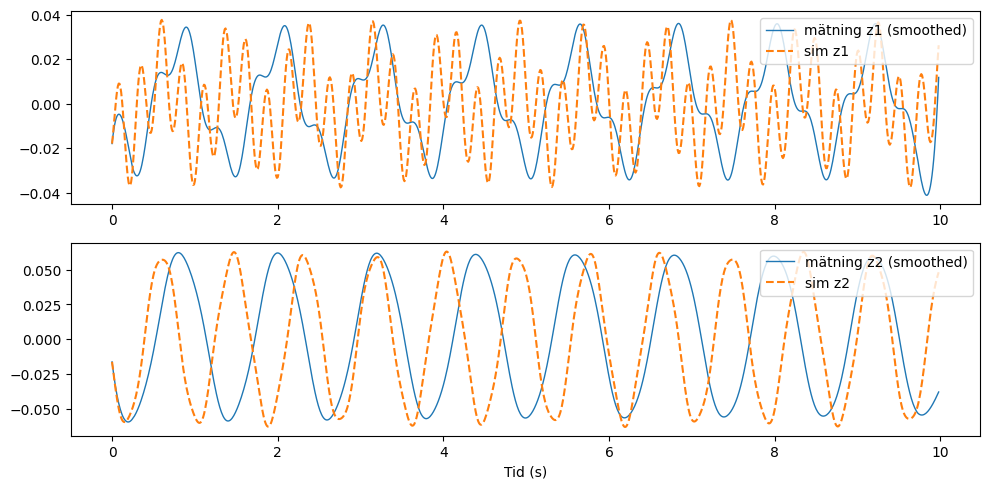

In [12]:
from scipy.signal import savgol_filter
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# välj dataset
df_raw = dfs["1_f1"].copy()  # byt till den fil du vill analysera
# kontrollera kolumnordning — justera om nödvändigt
df_raw.columns = ["x2", "y2", "z2", "x1", "y1", "z1"]

# Konvertera enheter om nödvändigt (ex: mm -> m)
df = df_raw / 1000.0   # antar mm -> m; ta bort om redan i meter

# Skapa tidsvektor baserat på antal samples och antagen dt
# Om du vet sampling rate, sätt dt_explicit = 0.01 (t.ex. 100 Hz). 
# Annars anta att inspelningen täcker 0..T sekunder (ange T själv) eller inferera dt från metadata.
N = len(df)
# Försök inferera dt: om du tidigare använde 0.01 och antal stämmer -> använd det
assumed_dt = 0.01 #10/N*len(row_range)
if abs((N*assumed_dt) - 10) < 1e-6:   # ditt tidigare t var från 0.01..10 med steg 0.01
    dt = assumed_dt
else:
    # Om du inte vet inspelningstid, anta dt = 0.01 som fallback, men var medveten
    dt = assumed_dt
    print(f"OBS: dt antaget = {dt}. Kontrollera samplingstiden (N={N}).")
    print(f"(N*dt-10) = {abs((N*assumed_dt) - 10)}")


t_data = np.arange(0, N*dt, dt)[:N]

# Smoothing + stabilare derivataberäkning
# Välj ett fönster som är udda och betydligt mindre än N (t.ex. fönster = 51 vid 100 Hz => 0.51 s)
win = 51 if N >= 51 else (N//2)*2+1  # säkerställ udda
poly = 3 if win > 3 else 1

z1 = df["z1"].values
z2 = df["z2"].values

z1_smooth = savgol_filter(z1, window_length=win, polyorder=poly)
z2_smooth = savgol_filter(z2, window_length=win, polyorder=poly)

dz1_dt = np.gradient(z1_smooth, dt)
dz2_dt = np.gradient(z2_smooth, dt)

# Subtrahera jämviktsläge (mean) om du vill ha små amplitude kring noll
z1_diff = z1_smooth - np.mean(z1_smooth)
z2_diff = z2_smooth - np.mean(z2_smooth)

save_z1_diff = pd.DataFrame(z1_diff)
save_z1_diff.to_csv("z1_diff.csv", index=False)

save_z2_diff = pd.DataFrame(z2_diff)
save_z2_diff.to_csv("z2_diff.csv", index=False)

# Läs av eller kontrollera dina parameter-värden (konvertera till SI)
vals = vals_1   # du använder vals_1 i ursprunglig kod; se till den är definierad
m1, m2, k1, k2 = vals["m1"], vals["m2"], vals["k1"], vals["k2"]
# Säkerställ att m i kg och k i N/m

print("Kontroll: N, dt, första z1,z2, första hastigheter")
print(N, dt, z1_diff[0], z2_diff[0], dz1_dt[0], dz2_dt[0])

# Define external forces (sätt till 0 om ingen extern kraft)
def f1(t): return 0.0
def f2(t): return 0.0

# ODE-system (samma formulering som du angav) — kontrollera tecken!
def deriv(t, X):
    x1, v1, x3, v3 = X
    dx1dt = v1
    dv1dt = (f1(t) + k2*(x3 - x1) - k1*x1) / m1
    dx3dt = v3
    dv3dt = (f2(t) - k2*(x3 - x1)) / m2
    return [dx1dt, dv1dt, dx3dt, dv3dt]

# Initialvillkor: använd den smoothed version för hastigheter
X0 = [z1_diff[0], dz1_dt[0], z2_diff[0], dz2_dt[0]]

# Lös ODE med t_data som utvärderingspunkter
t_span = (t_data[0], t_data[-1])
num_sol = solve_ivp(deriv, t_span, X0, t_eval=t_data, rtol=1e-8, atol=1e-9)

# Extrahera numerisk lösning
sim_z1 = num_sol.y[0]
sim_z2 = num_sol.y[2]



# Plotta mätning vs simulering
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t_data, z1_diff, label="mätning z1 (smoothed)", linewidth=1)
plt.plot(t_data, sim_z1, label="sim z1", linestyle="--")
plt.legend(loc='upper right')
plt.subplot(2,1,2)
plt.plot(t_data, z2_diff, label="mätning z2 (smoothed)", linewidth=1)
plt.plot(t_data, sim_z2, label="sim z2", linestyle="--")
plt.legend(loc='upper right')
plt.xlabel("Tid (s)")
plt.tight_layout()
plt.show()

### Numerisk lösning på systemet (1_f1.tsv)

In [6]:
# Define external forces f1(t), f2(t)
vals = vals_1
m1, m2, k1, k2 = vals["m1"], vals["m2"], vals["k1"], vals["k2"]

measure_nr = 0
def f1(t): 
    return 0#-9.82 * m1             # example: no forcing
def f2(t): 
    return 0#-9.82 * m2
# ODE system
def deriv(t, X):
    x1, x2, x3, x4 = X
    dx1dt = x2
    dx2dt = (f1(t) + k2*(x3 - x1) - k1*x1) / m1
    dx3dt = x4
    dx4dt = (f2(t) - k2*(x3 - x1)) / m2
    return [dx1dt, dx2dt, dx3dt, dx4dt]

# Initial conditions
#X0 = [df.z1[measure_nr]-np.mean(df.z1), np.gradient(df.z1, t)[0], df.z2[measure_nr]-np.mean(df.z2), np.gradient(df.z2, t)[0]]
X0 = [z1_diff[0], np.gradient(df.z1, t)[0], z2_diff[0], np.gradient(df.z2, t)[0]]


print(np.gradient(df.z1, t)[0])
print(np.gradient(df.z2, t)[0])


# Time span
num_t_span = (0, 10)
num_t_eval = t #np.linspace(*num_t_span, len(t))


# Solve numerically
num_sol = solve_ivp(deriv, num_t_span, X0, t_eval=num_t_eval, rtol=1e-8, atol=1e-9)

# Extract solutions
num_t = num_sol.t
num_y1, num_y2 = num_sol.y[0], num_sol.y[2]

0.1458999999999988
-0.37709999999999966


### Grafa resultat

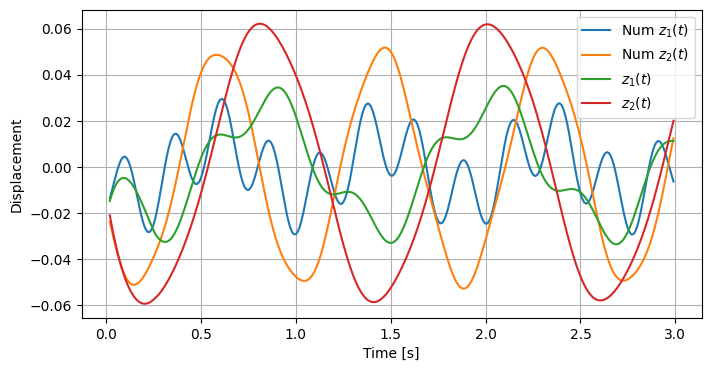

In [7]:
t_range = range(1, len(t)-700)

plt.figure(figsize=(8,4))
plt.plot(t[t_range], num_y1[t_range], label='Num $z_1(t)$')
plt.plot(t[t_range], num_y2[t_range], label='Num $z_2(t)$')
plt.plot(t[t_range], z1_diff[t_range], label="$z_1(t)$")
plt.plot(t[t_range], z2_diff[t_range], label="$z_2(t)$")
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend(loc=1)
plt.grid(True)
plt.show()

In [8]:
num_y2[0] == z2_diff[0]

np.False_

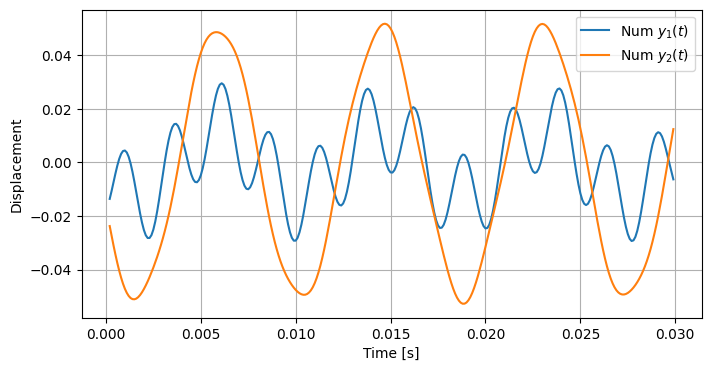

In [9]:
plt.figure(figsize=(8,4))
plt.plot(t[t_range]/100, num_y1[t_range], label='Num $y_1(t)$')
plt.plot(t[t_range]/100, num_y2[t_range], label='Num $y_2(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()

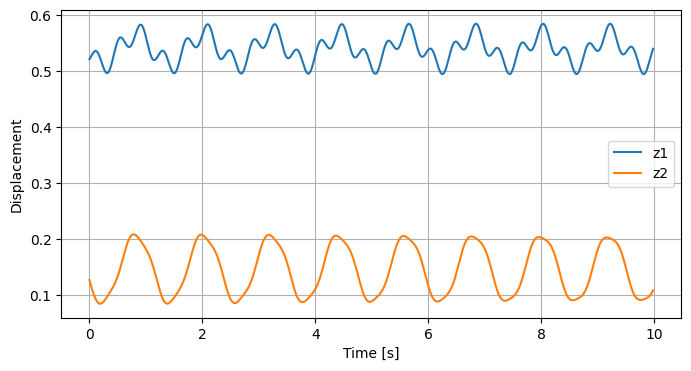

In [10]:
plt.figure(figsize=(8,4))
plt.plot(t_data, df.z1, label="z1")
plt.plot(t_data, df.z2, label="z2")
plt.xlabel('Time [s]')
plt.ylabel('Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
omega1 = 

SyntaxError: invalid syntax (3320195819.py, line 1)